# 영역 분할

영상에서 물체를 인식하고, 해당 물체를 픽셀 별로 구분하는 작업

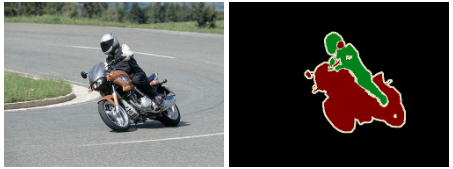

딥러닝으로는 일반적으로 encoder - decoder 구조를 사용한다. 

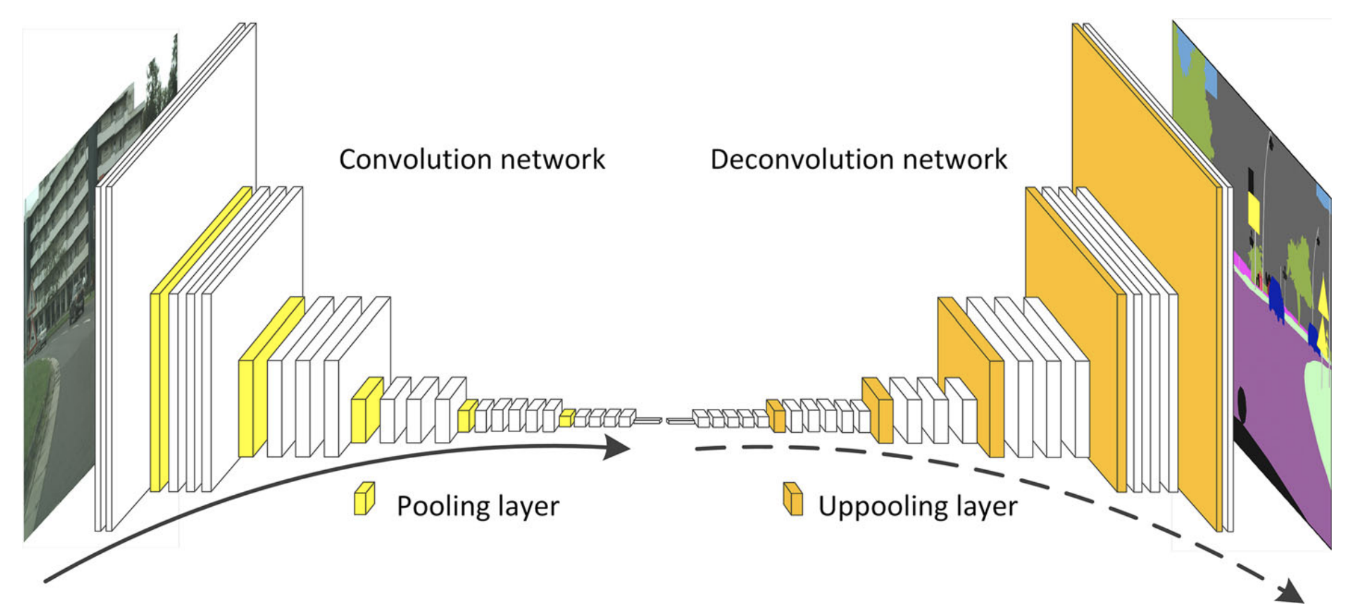

각 encoder와 decoder는 CNN의 conv 레이어와 deconv 레이어를 사용한다.

# DeepLab V3+

VOC 2012 데이터에 대한 영역 분할 작업에서 우수한 성능을 보이는 모델.

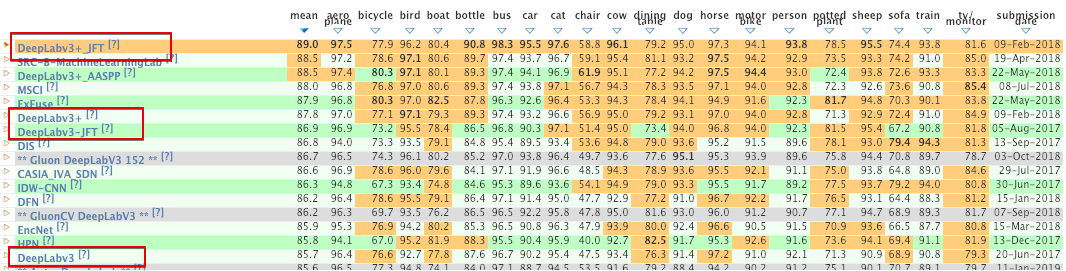

다음은 실시간으로 적용된 결과물

https://www.youtube.com/watch?v=ATlcEDSPWXY

초당 2.5개 정도를 처리하고 있다.


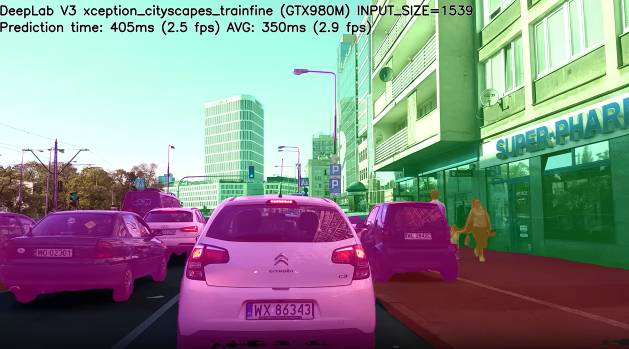

## 구조
인코더의 중간 값을 디코더의 중간에 포함시켰다. 이런 방법은 U-Net이라 한다.


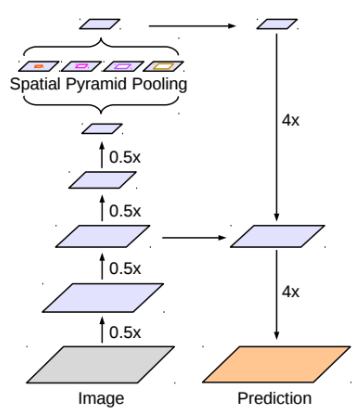

## 출력

각 픽셀 별로 클래스 인덱스를 구하는 것이 최종 출력


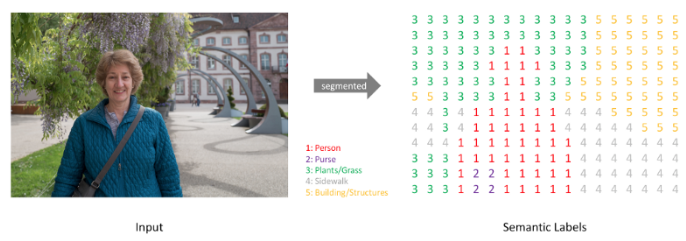

실제 모델에서는 각 클래스별 맵(map)이 출력된다.

20개의 클래스로 분류할 경우 20+1개(1개는 기타 혹은 배경)의 층으로 출력된다.


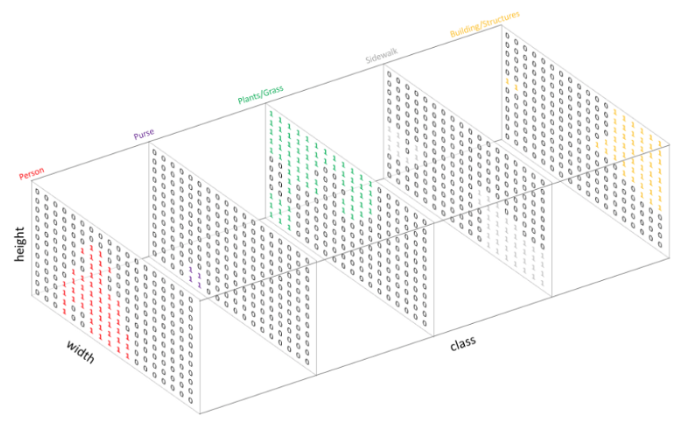

# 실습 준비

## Google Driver와 Colab 연동

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## 실행위치 이동

In [0]:
# 현재 위치
!pwd

# 실행 위치 이동
%cd "/content/gdrive/My Drive/04_영상인식_copied/CH9"

# 이동된 위치 확인
!pwd
!ls -al


/content
/content/gdrive/My Drive/04_영상인식_copied/CH9
/content/gdrive/My Drive/04_영상인식_copied/CH9
total 4157
drwx------ 2 root root    4096 Feb 18 02:24 data
drwx------ 2 root root    4096 Feb 18 08:15 .ipynb_checkpoints
drwx------ 2 root root    4096 Feb 21 05:45 keras-deeplab-v3-plus
drwx------ 2 root root    4096 Feb 15 05:48 Keras-segmentation-deeplab-v3.1
-rw------- 1 root root  645911 Feb 18 11:34 segmentation_190211.ipynb
-rw------- 1 root root 2948867 Feb 21 06:46 segmentation_190218.ipynb
-rw------- 1 root root  645076 Feb 15 04:29 segmentation.ipynb


# DeepLap V3+ 로 영역 분할

## 코드 다운로드

Keras로 구현한 https://github.com/bonlime/keras-deeplab-v3-plus의 코드를 다운로드 받는다.

실행 시에 VOC 데이터로 학습된 모델 파일을 다운로드 받는다.

In [0]:
%cd /content/gdrive/My Drive/04_영상인식_copied/CH9

!git clone https://github.com/bonlime/keras-deeplab-v3-plus

/content/gdrive/My Drive/04_영상인식_copied/CH9
Cloning into 'keras-deeplab-v3-plus'...
remote: Enumerating objects: 163, done.
remote: Total 163 (delta 0), reused 0 (delta 0), pack-reused 163
Receiving objects: 100% (163/163), 4.62 MiB | 12.48 MiB/s, done.
Resolving deltas: 100% (73/73), done.


## 이미지 준비

 512 x 512 의 입력으로 학습된 모델에 맞도록, 이미지를 읽어서 다음을 준비한다.
 
 - 사이즈를 512x512로 맞춤
 - 픽셀 값 0~255을 -1~1로 변경
 - 배치 처리를 고려하여 학습된 것에 맞게 데이터 모양 변경

/content/gdrive/My Drive/04_영상인식_copied/CH9/keras-deeplab-v3-plus


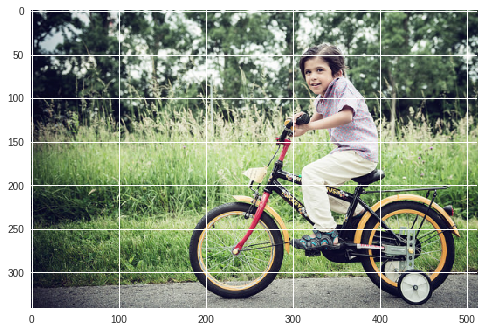

In [0]:
%cd '/content/gdrive/My Drive/04_영상인식_copied/CH9/keras-deeplab-v3-plus'

from matplotlib import pyplot as plt
import cv2 # used for resize. if you dont have it, use anything else
import numpy as np

img = plt.imread("imgs/image1.jpg")

# 이미지 사이즈르 512x512로 강제 맞춤
w, h, _ = img.shape
# w = 427, h = 640

ratio = 512. / np.max([w,h])
# ratio = 0.8 = 512/640 = 512/max(427,640)

resized = cv2.resize(img,(int(ratio*h),int(ratio*w)))
# resized.shape = (341, 512, 3)

pad_x = int(512 - resized.shape[0])
# 지금 가로는 341. 가로를 512로 맞추기 위해 모자라는 무분을 0으로 채움
resized2 = np.pad(resized,((0,pad_x),(0,0),(0,0)), mode='constant')
# resized2.shape = (512, 512, 3)


# 값들을 0~255의 값들을 -1~1로 변경
normalized = resized2 / 127.5 - 1.


# 여러개를 한번에 처리하는 배치를 고려한 모양으로 변경. 
# 맨 앞의 1은 1개를 의미.
ready_input = np.expand_dims(normalized,0)
# ready_input.shape = (1, 512, 512, 3)

plt.imshow(resized2[:-pad_x])

## 영역 분할 실행

/content/gdrive/My Drive/04_영상인식_copied/CH9/keras-deeplab-v3-plus


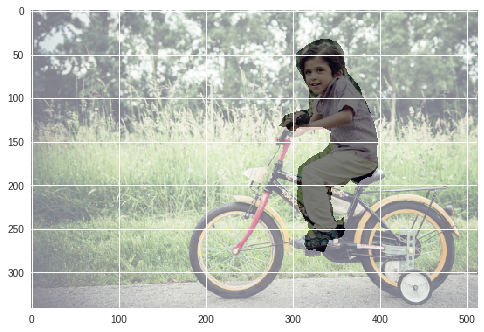

In [0]:
%cd '/content/gdrive/My Drive/04_영상인식_copied/CH9/keras-deeplab-v3-plus'

from model import Deeplabv3

# 모델 로딩
deeplab_model = Deeplabv3()

# 모델 예측 실행
result = deeplab_model.predict(ready_input)
# result.shape = (1, 512, 512, 21)


lable_image = result.squeeze()
# lable_image.shape = (512, 512, 21)

labels = np.argmax(lable_image,axis=-1)

plt.imshow(resized2[:-pad_x])
plt.imshow(labels[:-pad_x], alpha=.5)


#  커스텀 데이터 처리

이미지 파일과 각 파일별 segmentation 정보가 있는 레이블링 데이터가 필요하다.


## VOC 데이터 다운로드
전체 파일 크기가 크다. (1.6G)

실습에서는 150M만 받고 실행을 중지한다.

In [0]:
%cd "/content/gdrive/My Drive/04_영상인식_copied/CH9"
!mkdir data

!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -O data/VOCtrainval_11-May-2012.tar

/content/gdrive/My Drive/04_영상인식_copied/CH9
mkdir: cannot create directory ‘data’: File exists
--2019-02-18 10:07:06--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘data/VOCtrainval_11-May-2012.tar’

data/VOCtrainval_11 100%[===================>]   1.86G  12.4MB/s    in 2m 41s  

2019-02-18 10:09:47 (11.8 MB/s) - ‘data/VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



## 압축파일 풀기

'/content/gdrive/My Drive' 밑에 풀면 google drive간의 동기화 문제로 오류가 발생할 수 있다.

google drive 밖의 /tmp에 파일을 풀고 준비한다.


/content/gdrive/My Drive/04_영상인식_copied/CH9
/tmp/data/VOCdevkit/VOC2012
total 1384
drwxrwxrwx 7 root root   4096 May 11  2012 .
drwxrwxrwx 3 root root   4096 May 11  2012 ..
drwxrwxrwx 2 root root 577536 May 11  2012 Annotations
drwxrwxrwx 6 root root   4096 May 11  2012 ImageSets
drwxrwxrwx 2 root root 593920 May 11  2012 JPEGImages
drwxrwxrwx 2 root root 114688 May 11  2012 SegmentationClass
drwxrwxrwx 2 root root 114688 May 11  2012 SegmentationObject
total 1911776
drwxrwxrwx 2 root root 593920 May 11  2012 .
drwxrwxrwx 7 root root   4096 May 11  2012 ..
-rwxrwxrwx 1 root root 145493 Jan  9  2007 2007_000027.jpg
-rwxrwxrwx 1 root root  54757 Jan  9  2007 2007_000032.jpg
-rwxrwxrwx 1 root root  71205 Jan  9  2007 2007_000033.jpg
-rwxrwxrwx 1 root root  64668 Jan  9  2007 2007_000039.jpg
-rwxrwxrwx 1 root root  82847 Jan  9  2007 2007_000042.jpg
-rwxrwxrwx 1 root root  73156 Jan  9  2007 2007_000061.jpg
-rwxrwxrwx 1 root root 126171 Jan  9  2007 2007_000063.jpg


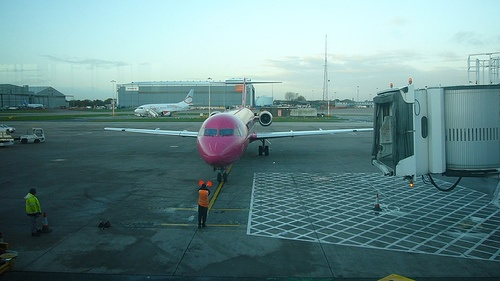


/tmp/data/VOCdevkit/VOC2012
total 1384
drwxrwxrwx 7 root root   4096 May 11  2012 .
drwxrwxrwx 3 root root   4096 May 11  2012 ..
drwxrwxrwx 2 root root 577536 May 11  2012 Annotations
drwxrwxrwx 6 root root   4096 May 11  2012 ImageSets
drwxrwxrwx 2 root root 593920 May 11  2012 JPEGImages
drwxrwxrwx 2 root root 114688 May 11  2012 SegmentationClass
drwxrwxrwx 2 root root 114688 May 11  2012 SegmentationObject

/tmp/data/SegmentationClassAug
total 51020
drwxrwxr-x 2 root root 430080 Dec 10  2014 .
drwxr-xr-x 4 root root   4096 Feb 21 04:14 ..
-rw-rw-r-- 1 root root   2035 Dec 10  2014 2007_000032.png
-rw-rw-r-- 1 root root   2556 Dec 10  2014 2007_000033.png
-rw-rw-r-- 1 root root   1249 Dec 10  2014 2007_000039.png
-rw-rw-r-- 1 root root   3241 Dec 10  2014 2007_000042.png
-rw-rw-r-- 1 root root   1912 Dec 10  2014 2007_000061.png
-rw-rw-r-- 1 root root   3564 Dec 10  2014 2007_000063.png
-rw-rw-r-- 1 root root   2445 Dec 10  2014 2007_000068.png
  12034  108299  709932


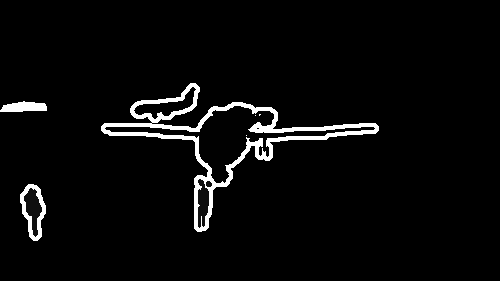

In [0]:
%cd "/content/gdrive/My Drive/04_영상인식_copied/CH9"

# 기존 폴더가 있으면 삭제하고, 새로 생성
!rm -rf /tmp/data
!mkdir /tmp/data 

# 다운받은 파일을 카피
!cp data/VOCtrainval_11-May-2012.tar /tmp/data/
!cp data/SegmentationClassAug.zip /tmp/data/

# 이미지 데이터 압축 푼다.
# 압출 풀때 'Segmentation', 'Annotations', 'ImageSets'를 제외
#!tar -xf /tmp/data/VOCtrainval_11-May-2012.tar  --exclude='Annotations' \
#         --exclude='ImageSets' --exclude='Segmentation*' -C /tmp/data

!tar -xf /tmp/data/VOCtrainval_11-May-2012.tar -C /tmp/data


# 결과 확인
!echo /tmp/data/VOCdevkit/VOC2012
!ls -al /tmp/data/VOCdevkit/VOC2012
!ls -al /tmp/data/VOCdevkit/VOC2012/JPEGImages | head -10

from IPython.display import Image, display
display(Image(filename='/tmp/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg'))


# 마스킹 데이터 압축 푼다.
!unzip -q /tmp/data/SegmentationClassAug.zip -d /tmp/data -x *MAC*

# 결과 확인
!echo; echo /tmp/data/VOCdevkit/VOC2012
!ls -al /tmp/data/VOCdevkit/VOC2012

!echo; echo /tmp/data/SegmentationClassAug
!ls -al /tmp/data/SegmentationClassAug | head -10
!ls -al /tmp/data/SegmentationClassAug | wc

display(Image(filename='/tmp/data/SegmentationClassAug/2007_000032.png'))



In [0]:
#!ls -al /tmp/data
#!tar -xf /tmp/data/VOCtrainval_11-May-2012.tar -C /tmp/data
!ls -al /tmp/data/VOCdevkit/VOC2012
!ls -al /tmp/data/VOCdevkit/VOC2012/SegmentationClass | head -10
!ls -al /tmp/data/VOCdevkit/VOC2012/SegmentationClass | wc

total 1384
drwxrwxrwx 7 root root   4096 May 11  2012 .
drwxrwxrwx 3 root root   4096 May 11  2012 ..
drwxrwxrwx 2 root root 577536 May 11  2012 Annotations
drwxrwxrwx 6 root root   4096 May 11  2012 ImageSets
drwxrwxrwx 2 root root 593920 May 11  2012 JPEGImages
drwxrwxrwx 2 root root 114688 May 11  2012 SegmentationClass
drwxrwxrwx 2 root root 114688 May 11  2012 SegmentationObject
total 14072
drwxrwxrwx 2 root root 114688 May 11  2012 .
drwxrwxrwx 7 root root   4096 May 11  2012 ..
-rwxrwxrwx 1 root root   2334 Mar 21  2007 2007_000032.png
-rwxrwxrwx 1 root root   2814 Mar 21  2007 2007_000033.png
-rwxrwxrwx 1 root root   1698 Mar 21  2007 2007_000039.png
-rwxrwxrwx 1 root root   3620 Mar 21  2007 2007_000042.png
-rwxrwxrwx 1 root root   2309 Mar 21  2007 2007_000061.png
-rwxrwxrwx 1 root root   3540 Mar 21  2007 2007_000063.png
-rwxrwxrwx 1 root root   2523 Mar 21  2007 2007_000068.png
   2916   26237  171970


In [0]:
!ls -al /tmp/data/VOCdevkit/VOC2012/ImageSets/Segmentation | head -10

total 84
drwxrwxrwx 2 root root  4096 May 11  2012 .
drwxrwxrwx 6 root root  4096 May 11  2012 ..
-rwxrwxrwx 1 root root 17568 May 11  2012 train.txt
-rwxrwxrwx 1 root root 34956 May 11  2012 trainval.txt
-rwxrwxrwx 1 root root 17388 May 11  2012 val.txt


## 학습 데이터 준비

In [0]:
# mask 데이터 카피
!mkdir -p /tmp/data/train/mask/0
!cp /tmp/data/SegmentationClassAug/* /tmp/data/train/mask/0/

# mask 데이터가 있는 이미지 파일만 카피
!mkdir -p /tmp/data/train/image/0
!VOC=/tmp/data/VOCdevkit/VOC2012; \
for idx in $(ls /tmp/data/train/mask/0/*.png); do \
  mv $VOC/JPEGImages/$(basename $idx .png).jpg /tmp/data/train/image/0/ ;\
done



## 이미지 파일과 mask 파일 숫자 확인

In [0]:

#원본파일과 Segementation 파일의 개수를 센다.
!ls /tmp/data/train/image/0 | wc -l
!ls /tmp/data/train/mask/0 | wc -l



12031
12031


## 학습에 사용될 Data Generator

ImageDataGenerator의 flow_from_directory()를 사용.

flow_from_directory()에는 이미지들이 담긴 디렉토리의 상위 디렉토리가 설정된다.

Using TensorFlow backend.


(281, 500, 3)
[128.   0.   0.]


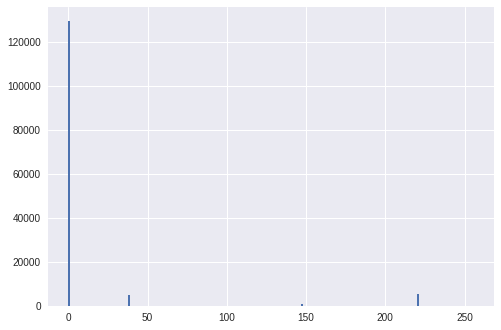

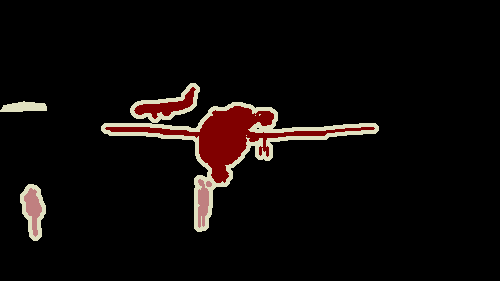

[129545, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5355, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
256


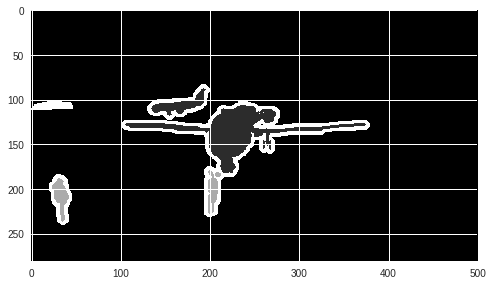

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('/tmp/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png')
x = img_to_array(img)  
print(x.shape)
print(x[140,250])


import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('/tmp/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()

from IPython.display import Image, display
display(Image(filename='/tmp/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'))


import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#%matplotlib inline

img = Image.open('/tmp/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png').convert('RGB').convert('L')
img.show()
arr = np.array(img)
plt.imshow(arr, cmap='gray')

hist = img.histogram()
print(hist)
print(len(hist))


In [0]:
# copy from https://github.com/tensorflow/models/blob/master/research/deeplab/utils/get_dataset_colormap.py

def bit_get(val, idx):
  return (val >> idx) & 1

def create_pascal_label_colormap():
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= bit_get(ind, channel) << shift
    ind >>= 3

  return colormap

def rgb2gray(rgb):
    return int(np.dot(rgb, [0.299, 0.587, 0.114]))

# VOC의 labeling 값이 담긴 png파일에서 사용하는 labeling값들. 
def get_labeling_value(n_class):

  color_map = create_pascal_label_colormap()

  class_number = []
  for rgb in color_map[1:n_class+1]:
    class_number.append(rgb2gray(rgb))
    
  class_number.append(rgb2gray(color_map[-1])) # void에 해당하는 값.
  
  return class_number

  

In [0]:
  
# VOC의 labeling 값이 담긴 png파일에서 사용하는 labeling 값들.   
labeling_value = get_labeling_value(20)
# 20개의 class에 대항하는 label 값과 배경에 해당하는 220
# labeling_value = [38, 75, 113, 14, 52, 89, 127, 19, 57, 94, 132, 33, 72, 108, 147, 37, 75, 112, 150, 52, 220]

  
# VOC의 SegmentationClass 디릭토리에 있는 png 파일의 값으로
# DeepLabV3+의 학습에 사용될 y데이터로 변환한다.
# png의 값은 512x512x1의 모댱이며
# 반환되는 값은 512x512x21이다. (21 = 20개 class + 1개 배경)
# 특정 픽셀 (x,y)가 클래스 3에 해당하면 [x][y][3-1]의 값만 1이고, [x][y][이외]는 전부 0이다.
def convert_png_mask_into_deeplabv3_output(png_mask):

  # 반환할 512x512x20의 어레이. 전부 0으로 차 있다.
  deeplabv3_output = np.zeros((512,512,21))

  for i, label in enumerate(labeling_value):
    a_class = np.copy(png_mask).reshape(512,512)
    np.putmask(a_class, a_class!=label, 0) # 대상 클래스 번호가 아닌 것은 전부 0으로.
    np.putmask(a_class, a_class==label, 1) # 대상 클래스 번호인 것은 1로.
    deeplabv3_output[:,:,i] = a_class
   
  return deeplabv3_output

def convert_png_mask_batch_into_deeplabv3_output_batch(png_mask_batch):

  deeplabv3_output_batch = np.zeros((png_mask_batch.shape[0], 512, 512, 21))
  
  for i in range(png_mask_batch.shape[0]):
    deeplabv3_output_batch[i] = convert_png_mask_into_deeplabv3_output(png_mask_batch[i])
  
  return deeplabv3_output_batch
  


In [0]:
from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

image_generator = image_datagen.flow_from_directory(
    '/tmp/data/train/image',
    target_size = (512, 512),
    batch_size=1,
    class_mode = None,
    seed = seed)

mask_generator = mask_datagen.flow_from_directory(
    '/tmp/data/train/mask',
    target_size = (512, 512),
    batch_size=1,
    class_mode = None,
    color_mode = "grayscale",
    seed = seed)



class MyIterator:
  
  def __init__(self, source):
    self.source = source
    
  def __iter__(self):
    org = self.source.__iter__()
    return MyIterator(org)
  
  def __next__(self):
    org = self.source.__next__()
    org = convert_png_mask_batch_into_deeplabv3_output_batch(org) # DEV
    return org
  
print(mask_generator)
mask_generator = MyIterator(mask_generator)

my_iter = iter(mask_generator)
r = next(my_iter)
print(r.shape)


train_generator = zip(image_generator, mask_generator)
  
  


Found 12031 images belonging to 1 classes.
Found 12031 images belonging to 1 classes.
(1, 512, 512, 21)


## 학습 실행

In [0]:
%cd '/content/gdrive/My Drive/04_영상인식_copied/CH9/keras-deeplab-v3-plus'

from model import Deeplabv3

# 이미 학습되어 있는 모델을 읽는다.
model = Deeplabv3(input_shape=(512,512,3), classes=21)


  
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy","binary_crossentropy"])


history = model.fit_generator(
      train_generator,
#      steps_per_epoch=image_generator.samples/image_generator.batch_size,
      steps_per_epoch=1000,
      # epochs=10,
      epochs=1, # DEV
      verbose=1)


# 학습된 모델을 저장
model.save('new_trained_on_voc.h5')


/content/gdrive/My Drive/04_영상인식_copied/CH9/keras-deeplab-v3-plus
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 256, 256, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 256, 256, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 256, 256, 32) 0           Conv_BN[0][0]                    
___________________________________

## 학습된 모델로 영역 분할 실행

/content/gdrive/My Drive/04_영상인식_copied/CH9/keras-deeplab-v3-plus
(1, 512, 512, 21)


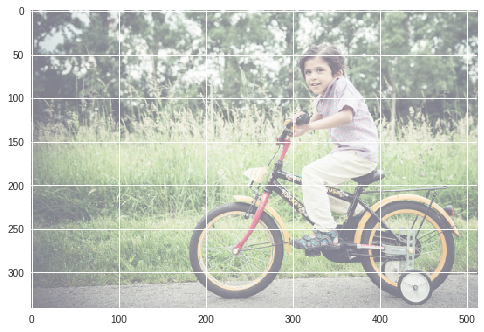

In [0]:
%cd '/content/gdrive/My Drive/04_영상인식_copied/CH9/keras-deeplab-v3-plus'

from model import Deeplabv3

# 모델 로딩
deeplab_model = Deeplabv3(input_shape=(512,512,3), classes=21)
deeplab_model.load_weights('new_trained_on_voc.h5')


# 모델 예측 실행
result = deeplab_model.predict(ready_input)
# result.shape = (1, 512, 512, 21)


lable_image = result.squeeze()
# lable_image.shape = (512, 512, 21)

labels = np.argmax(lable_image,axis=-1)

plt.imshow(resized2[:-pad_x])
plt.imshow(labels[:-pad_x], alpha=.5)


# Referece

- 실습에 사용된 코드 : https://github.com/bonlime/keras-deeplab-v3-plus
- DeepLab V3 논문 : https://arxiv.org/pdf/1606.00915.pdf
- Segementation Overview 아티클 : https://www.jeremyjordan.me/semantic-segmentation/
- 입출력 설명에 사용된 이미지 : https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb
- VOC 이미지의 윤곽선  데이타. : http://home.bharathh.info/pubs/codes/SBD/download.html
